<h2>Libraries and functions used throughout the notebook</h2>

In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import networkx as nx
import pycountry
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_rows', None) # Comment this out if needed

def get_sentiment(text):
    if text == 0:
        return 'NaN'
    return TextBlob(text).sentiment.polarity

def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
def get_neighbors_from_api(country_code):
    url = f"https://restcountries.com/v3.1/alpha/{country_code}"
    response = requests.get(url)
    if response.status_code == 200:
        country_data = response.json()
        return country_data[0].get('borders', [])
    return []

def get_neighbors(iso_code):
    if iso_code in G:
        return list(G.neighbors(iso_code))
    return []

def countries_in_conflict(year):
    return final_merged_dataframe[(final_merged_dataframe['year'] == year) & (final_merged_dataframe['intensity_level'] > 0)]['ISO-alpha3 Code'].dropna().values

def has_neighbor_in_conflict(row):
    if pd.isna(row['ISO-alpha3 Code']):
        return False
    neighbors = get_neighbors(row['ISO-alpha3 Code'])
    conflicting_countries = countries_in_conflict(row['year'])
    return any(neighbor in conflicting_countries for neighbor in neighbors)

def select_row(group):
    if (group['intensity_level'] == 2).any():
        return group[group['intensity_level'] == 2].iloc[0]
    elif (group['intensity_level'] == 1).any():
        return group[group['intensity_level'] == 1].iloc[0]
    else:
        return group.iloc[0]

<h2>Import the Datasets</h2>

A few country names in the datasets have been hardcoded to a more convenient name

In [2]:
# Happiness dataset

happinessdataframe = pd.read_csv('happiness_clean.csv')

happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Brazzaville)', 'Country name'] = 'Congo'
happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Kinshasa)', 'Country name'] = 'Congo'

In [3]:
# Conflict dataset

conflictdataframe = pd.read_csv('conflict_clean.csv')

conflict_post2004 = conflictdataframe[conflictdataframe['year'] > 2004]
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union)', 'location'] = 'Russia'
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union), Ukraine', 'location'] = 'Ukraine'
conflict_post2004.loc[conflict_post2004['location'] == 'DR Congo (Zaire)', 'location'] = 'Congo'

conflictdataframe = conflict_post2004

In [4]:
# Apply country code to conflict dataframes

conflictdataframe['Country Code'] = conflictdataframe['location'].apply(get_country_code)

In [5]:
# UN Speeches

ungdc = pd.read_parquet('UNGDC_1946-2023_processed.parquet')

<h2>Merging Datasets</h2>

In [6]:
# Merge happiness and conflict

merged_dataframe = pd.merge(
    happinessdataframe, 
    conflictdataframe, 
    how='left',
    left_on=['Country name', 'year'], 
    right_on=['location', 'year']
)

merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region,Country Code
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG


In [7]:
# Merge ungdc

final_merged_dataframe = pd.merge(
    merged_dataframe, 
    ungdc, 
    how='left',
    left_on=['year', 'Country Code'],
    right_on=['Year', 'ISO-alpha3 Code']
)

final_merged_dataframe.fillna(0, inplace=True)

final_merged_dataframe['sentiment'] = final_merged_dataframe['Speech'].apply(get_sentiment)

final_merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region,Country Code,Session,Year,ISO-alpha3 Code,Speech,sentiment
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG,63,2008.0,AFG,Since the last time we \ngathered here in this...,0.195246
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG,64,2009.0,AFG,"First, I would like to \ncongratulate His Exce...",0.146516
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG,65,2010.0,AFG,I join previous \nspeakers in congratulating y...,0.140513
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG,66,2011.0,AFG,I am honoured to be \nhere to read the stateme...,0.103318
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3,AFG,67,2012.0,AFG,"﻿As we speak today, the world\nis being shaken...",0.11543


In [8]:
# For neighbour column

G = nx.Graph()

for iso_code in final_merged_dataframe['ISO-alpha3 Code'].unique():
    if pd.notna(iso_code):
        neighbors = get_neighbors_from_api(iso_code)
        for neighbor in neighbors:
            G.add_edge(iso_code, neighbor)

final_merged_dataframe['neighbor_in_conflict'] = final_merged_dataframe.apply(has_neighbor_in_conflict, axis=1)

In [9]:
final_merged_dataframe.head()

# Comment out if you want to export the dataset

# final_merged_datasets.to_csv('final_dataset_raw.csv')

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Unnamed: 0_y,conflict_id,location,...,intensity_level,type_of_conflict,region,Country Code,Session,Year,ISO-alpha3 Code,Speech,sentiment,neighbor_in_conflict
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,1688.0,333.0,Afghanistan,...,2.0,4.0,3,AFG,63,2008.0,AFG,Since the last time we \ngathered here in this...,0.195246,True
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,1696.0,333.0,Afghanistan,...,2.0,4.0,3,AFG,64,2009.0,AFG,"First, I would like to \ncongratulate His Exce...",0.146516,True
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,1697.0,333.0,Afghanistan,...,2.0,4.0,3,AFG,65,2010.0,AFG,I join previous \nspeakers in congratulating y...,0.140513,True
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,1706.0,333.0,Afghanistan,...,2.0,4.0,3,AFG,66,2011.0,AFG,I am honoured to be \nhere to read the stateme...,0.103318,True
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,1707.0,333.0,Afghanistan,...,2.0,4.0,3,AFG,67,2012.0,AFG,"﻿As we speak today, the world\nis being shaken...",0.11543,True


<h2>Graph for country's affect and conflict</h2>

Only change 'country' variable to see the graph

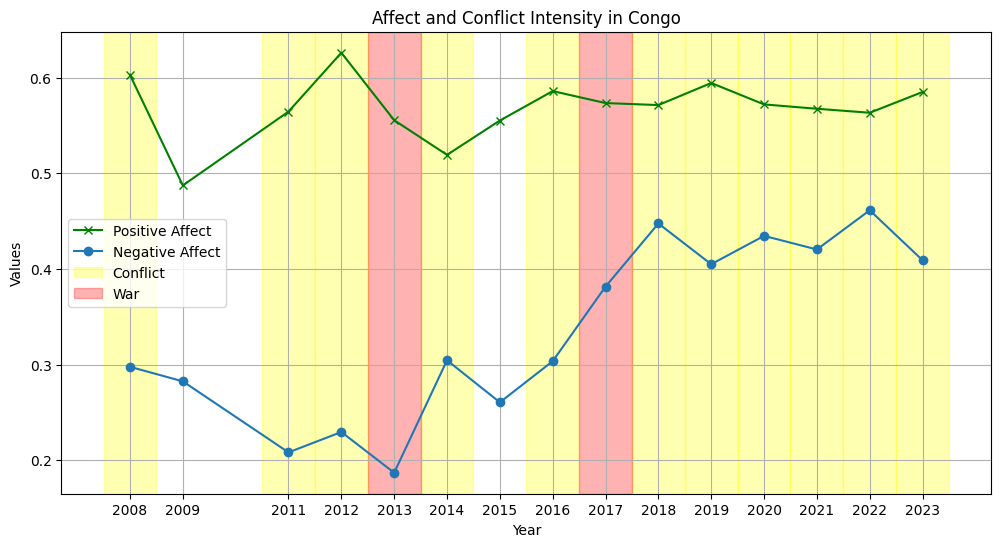

In [10]:
country = 'Congo'

after_2005 = conflictdataframe

conflicts = after_2005[after_2005['location'] == country]
happiness = happinessdataframe[happinessdataframe['Country name'] == country]
    
merged_df = pd.merge(conflicts, happiness, on='year', how='outer')
merged_df.fillna(0, inplace=True)
merged_df = merged_df.sort_values(by='year', ascending=True)
merged_df = merged_df.groupby('year', group_keys=False).apply(select_row)
merged_df = merged_df.loc[(merged_df['Positive affect'] != 0.000) & (merged_df['Negative affect'] != 0.000)]

plt.figure(figsize=(12, 6))
plt.plot(merged_df['year'], merged_df['Positive affect'], label='Positive Affect', color='green', marker='x')
plt.plot(merged_df['year'], merged_df['Negative affect'], label='Negative Affect', marker='o')

for i in range(len(merged_df)):
    intensity_level = merged_df['intensity_level'].iloc[i]
    year = merged_df['year'].iloc[i]
    
    if intensity_level == 1:
        plt.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3, label='Conflict')

for i in range(len(merged_df)):
    intensity_level = merged_df['intensity_level'].iloc[i]
    year = merged_df['year'].iloc[i]
    
    if intensity_level == 2:
        plt.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3, label='War')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title(f'Affect and Conflict Intensity in {country}')
plt.xticks(merged_df['year'].astype(int))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates by using dictionary
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)

plt.show()

<h2>Bayesian classifier</h2>

In [ ]:
df = pd.read_excel('final_dataset_processed.xlsx')

X_train, X_test, y_train, y_test = train_test_split(df['Speech'], df['neighbor_in_conflict'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))